#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Aivle/DL/AI_미니프로젝트 1차_실습자료/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
# 주어진 데이터 셋을 불러오세요.(3개)
train_data = pd.read_csv(path + 'data01_train.csv')
test_data = pd.read_csv(path + 'data01_test.csv')
feature_data = pd.read_csv(path + 'features.csv')

In [ ]:
#불필요한 칼럼을 삭제하세요.
train_data.drop(['subject'], axis=1, inplace=True)
test_data.drop(['subject'], axis=1, inplace=True)

In [ ]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
train_data.shape

(5881, 562)

In [ ]:
#전체 데이터의 상위 5개 행 확인
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
tBodyAcc-mean()-X,5881.0,0.274811,0.067614,-0.503823,0.262919,0.277154,0.288526,1.000000
tBodyAcc-mean()-Y,5881.0,-0.017799,0.039422,-0.684893,-0.024877,-0.017221,-0.010920,1.000000
tBodyAcc-mean()-Z,5881.0,-0.109396,0.058373,-1.000000,-0.121051,-0.108781,-0.098163,1.000000
tBodyAcc-std()-X,5881.0,-0.603138,0.448807,-1.000000,-0.992774,-0.943933,-0.242130,1.000000
tBodyAcc-std()-Y,5881.0,-0.509815,0.501815,-0.999844,-0.977680,-0.844575,-0.034499,0.916238
...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",5881.0,0.009340,0.608190,-1.000000,-0.481718,0.011448,0.499857,0.998702
"angle(tBodyGyroJerkMean,gravityMean)",5881.0,-0.007099,0.476738,-1.000000,-0.373345,-0.000847,0.356236,0.996078
"angle(X,gravityMean)",5881.0,-0.491501,0.509069,-1.000000,-0.811397,-0.709441,-0.511330,0.977344
"angle(Y,gravityMean)",5881.0,0.059299,0.297340,-1.000000,-0.018203,0.182893,0.248435,0.478157


In [ ]:
#전체 데이터의 모든 변수 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [ ]:
# 데이터 분할을 합니다.
x_train, y_train = train_data.drop(['Activity'], axis=1), train_data['Activity']

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = MinMaxScaler()
x_train_minmax = scaler.fit_transform(x_train)
x_val_minmax = scaler.transform(x_val)

In [ ]:
scaler = StandardScaler()
x_train_standard = scaler.fit_transform(x_train)
x_val_standard = scaler.transform(x_val)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [ ]:
# 정수 인코딩 변환(LabelEncoder)
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_val_le = le.transform(y_val)

In [ ]:
# 기존 레이블 저장
labels = le.classes_

In [ ]:
labels

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [ ]:
from keras.utils import to_categorical

# One-Hot Encoding
y_train_onehot = to_categorical(y_train_le, num_classes=len(labels))
y_val_onehot = to_categorical(y_val_le, num_classes=len(labels))

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [ ]:
x_train_minmax.shape[1]

561

In [ ]:
# 모델 설계
model_ln = Sequential()
model_ln.add(Dense(len(labels), input_dim=x_train_minmax.shape[1], activation='softmax'))
model_ln.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 6)              │         3,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',          # 개선 여부를 체크할 지표 (검증 손실)
    patience=5,                  # 5번의 epoch 동안 개선이 없으면 학습 중단
    restore_best_weights=True   # 가장 좋은 성능을 보였을 때의 모델 가중치 복원
)

In [ ]:
# 컴파일 및 학습
model_ln.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


history = model_ln.fit(x_train_minmax, y_train_onehot, epochs=100, batch_size=32, validation_data=(x_val_minmax, y_val_onehot), callbacks=[early_stopping]
)

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3485 - loss: 0.4288 - val_accuracy: 0.8207 - val_loss: 0.2784
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8013 - loss: 0.2657 - val_accuracy: 0.8530 - val_loss: 0.2250
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8490 - loss: 0.2205 - val_accuracy: 0.8802 - val_loss: 0.1922
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8693 - loss: 0.1882 - val_accuracy: 0.8989 - val_loss: 0.1703
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8791 - loss: 0.1716 - val_accuracy: 0.9142 - val_loss: 0.1526
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8899 - loss: 0.1552 - val_accuracy: 0.9099 - val_loss: 0.1403
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8969 - loss: 0.1417 - val_accuracy: 0.9125 - val_loss: 0.1304
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9028 - loss: 0.1330 - val_accu

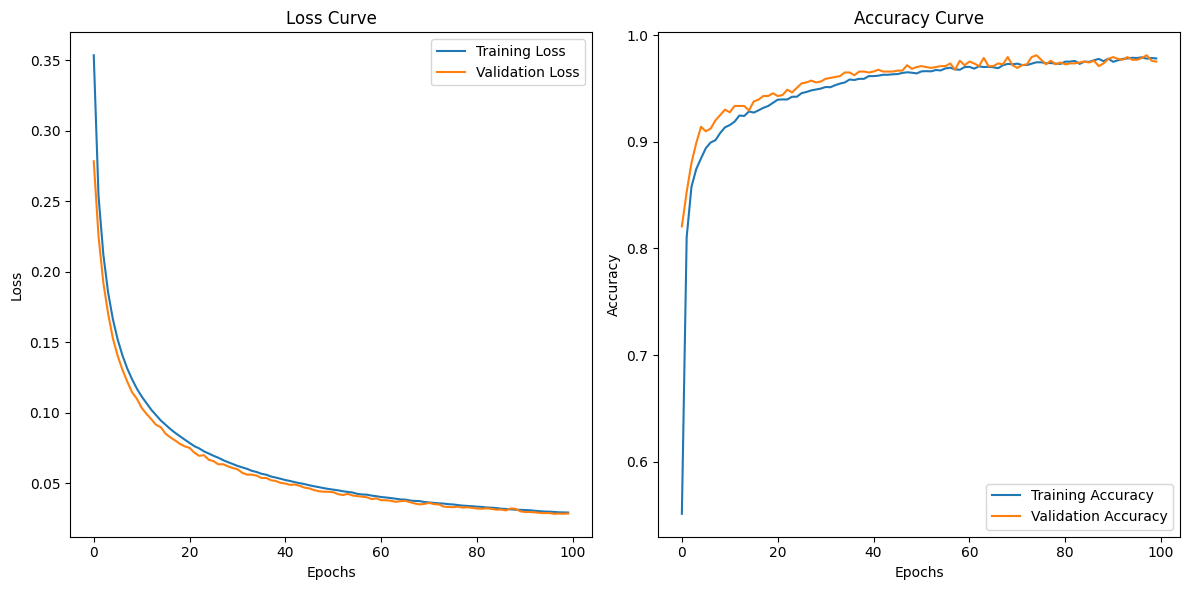

In [ ]:
# 학습곡선
# 훈련 손실과 검증 손실
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 훈련 정확도와 검증 정확도
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 예측 및 평가
y_pred_prob = model_ln.predict(x_val_minmax)  # 예측 결과 (확률값)

# 예측 결과를 클래스 레이블로 변환
y_pred = le.inverse_transform(y_pred_prob.argmax(axis=1))  # 확률값에서 가장 큰 값의 인덱스를 가져와서 클래스 레이블로 변환

# 평가 (손실과 정확도)
loss, accuracy = model_ln.evaluate(x_val_minmax, y_val_onehot)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9783 - loss: 0.0260
Validation Loss: 0.028323382139205933
Validation Accuracy: 0.9787595868110657


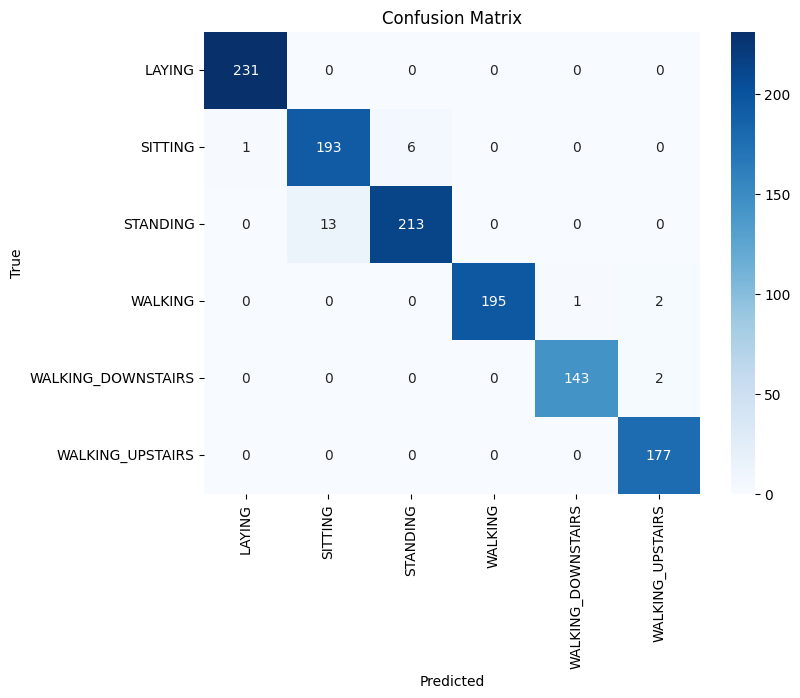

In [ ]:
# 실제 레이블과 예측된 레이블을 비교
cm = confusion_matrix(y_val, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!
# 반복 횟수 설정 (5번)
num_repeats = 5

# 모델 성능을 저장할 리스트
accuracy_list = []

# 모델을 5번 반복 학습하고 평가하기
for i in range(num_repeats):
    print(f"Run {i + 1}/{num_repeats}")

    # 세션 초기화 (이전 모델의 메모리 해제를 위해)
    clear_session()

    # 새로운 모델 초기화 (각 반복마다 새로 초기화하여 훈련)
    model = Sequential()
    model.add(Dense(len(labels), input_dim=x_train_minmax.shape[1], activation='softmax'))

    # 모델 컴파일
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # EarlyStopping 콜백 설정
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 모델 학습
    history = model.fit(x_train_minmax, y_train_onehot,
                         epochs=50,
                         batch_size=32,
                         validation_data=(x_val_minmax, y_val_onehot),
                         callbacks=[early_stopping],
                         verbose=0)  # 학습과정은 출력하지 않음

    # 모델 평가 (검증 데이터에서 성능 평가)
    loss, accuracy = model.evaluate(x_val_minmax, y_val_onehot, verbose=0)
    accuracy_list.append(accuracy)

# 평균 정확도 계산
average_accuracy = np.mean(accuracy_list)

print(f"\nAverage Accuracy over {num_repeats} runs: {average_accuracy:.4f}")

Run 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 2/5
Run 3/5
Run 4/5
Run 5/5

Average Accuracy over 5 runs: 0.9784


### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [ ]:
x_train_minmax.shape[1]

561

In [ ]:
# 모델 설계
model_hd = Sequential()
model_hd.add(Dense(256, input_dim=x_train_minmax.shape[1], activation='relu'))
model_hd.add(Dense(128, input_dim=256, activation='relu'))
model_hd.add(Dense(64, input_dim=128, activation='relu'))
model_hd.add(Dense(32, input_dim=64, activation='relu'))
model_hd.add(Dense(16, input_dim=32, activation='relu'))
model_hd.add(Dense(len(labels), input_dim=16, activation='softmax'))

In [ ]:
# 컴파일 및 학습
model_hd.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


history = model_hd.fit(x_train_minmax, y_train_onehot, epochs=100, batch_size=32, validation_data=(x_val_minmax, y_val_onehot), callbacks=[early_stopping],
)

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4326 - loss: 0.4059 - val_accuracy: 0.7562 - val_loss: 0.1461
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7956 - loss: 0.1440 - val_accuracy: 0.8734 - val_loss: 0.0990
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8905 - loss: 0.0987 - val_accuracy: 0.9091 - val_loss: 0.0766
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9222 - loss: 0.0665 - val_accuracy: 0.9431 - val_loss: 0.0506
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9494 - loss: 0.0447 - val_accuracy: 0.9643 - val_loss: 0.0291
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9522 - loss: 0.0414 - val_accuracy: 0.9609 - val_loss: 0.0352
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9573 - loss: 0.0357 - val_accuracy: 0.9507 - val_loss: 0.0379
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9653 - loss: 0.0316 - val_accu

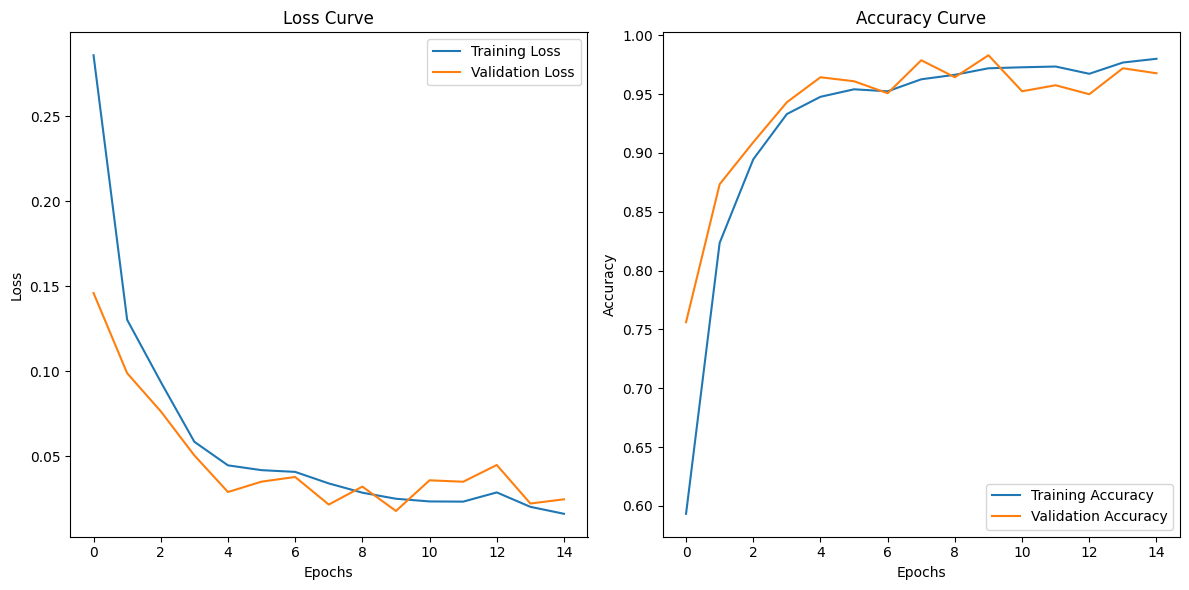

In [ ]:
# 학습곡선

# 훈련 손실과 검증 손실
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 훈련 정확도와 검증 정확도
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 예측 및 평가

y_pred_prob = model_hd.predict(x_val_minmax)  # 예측 결과 (확률값)

# 예측 결과를 클래스 레이블로 변환
y_pred = le.inverse_transform(y_pred_prob.argmax(axis=1))  # 확률값에서 가장 큰 값의 인덱스를 가져와서 클래스 레이블로 변환

# 평가 (손실과 정확도)
loss, accuracy = model_hd.evaluate(x_val_minmax, y_val_onehot)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9828 - loss: 0.0170
Validation Loss: 0.01794377714395523
Validation Accuracy: 0.9830076694488525


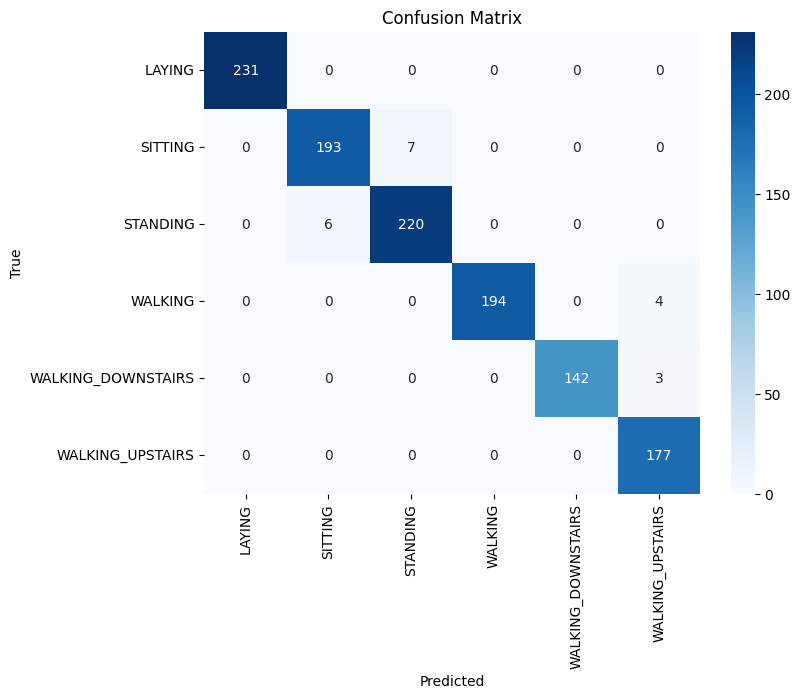

In [ ]:
# 실제 레이블과 예측된 레이블을 비교
cm = confusion_matrix(y_val, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### (3) 모델3 : 학습률, epoch 등 조정

In [ ]:
# 모델 설계

In [ ]:
# 컴파일 및 학습

In [ ]:
# 학습곡선

In [ ]:
# 예측 및 평가

### (4) 모델4 :  학습률, epoch 등 조정

In [ ]:
# 모델 설계

In [ ]:
# 컴파일 및 학습

In [ ]:
# 학습곡선

In [ ]:
# 예측 및 평가

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [ ]:
#전체 데이터 불러오기(test)

# x, y 분할
x_test, y_test = test_data.drop(['Activity'], axis=1), test_data['Activity']
# x : 스케일링 적용
x_test_minmax = scaler.transform(x_test)
# y : 정수인코딩 적용
y_test_le = le.transform(y_test)
y_test_onehot = to_categorical(y_test_le, num_classes=len(labels))

In [ ]:
# 모델1 평가
loss1, acc1 = model_hd.evaluate(x_test_minmax, y_test_onehot, verbose=0)

# 모델2 평가
loss2, acc2 = model_ln.evaluate(x_test_minmax, y_test_onehot, verbose=0)

# 비교 출력
print(f"📊 Model hidden - Test Accuracy: {acc1:.4f}, Loss: {loss1:.4f}")
print(f"📊 Model non hidden - Test Accuracy: {acc2:.4f}, Loss: {loss2:.4f}")

📊 Model hidden - Test Accuracy: 0.9674, Loss: 0.0277
📊 Model non hidden - Test Accuracy: 0.9694, Loss: 0.0348


In [ ]:
# Model 1 예측
y_pred1 = model_hd.predict(x_test_minmax)
y_pred1_label = le.inverse_transform(y_pred1.argmax(axis=1))

# Model 2 예측
y_pred2 = model_ln.predict(x_test_minmax)
y_pred2_label = le.inverse_transform(y_pred2.argmax(axis=1))

# classification_report 출력
print("📋 Model hidden Classification Report:")
print(classification_report(y_test, y_pred1_label, target_names=labels))

print("📋 Model non hidden Classification Report:")
print(classification_report(y_test, y_pred2_label, target_names=labels))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📋 Model hidden Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.95      0.89      0.92       254
          STANDING       0.91      0.96      0.93       287
           WALKING       1.00      0.98      0.99       228
WALKING_DOWNSTAIRS       1.00      0.98      0.99       195
  WALKING_UPSTAIRS       0.96      1.00      0.98       215

          accuracy                           0.97      1471
         macro avg       0.97      0.97      0.97      1471
      weighted avg       0.97      0.97      0.97      1471

📋 Model non hidden Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.94      0.92      0.93       254
          STANDING       0.93      0.94      0.94       28

#### 고생하셨습니다! 이제 단계적 모델링을 해봅시다.